In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2025-02-26 13:41:12.854048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-26 13:41:12.923174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-26 13:41:12.941902: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 13:41:13.042201: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-26 13:41:14.470920: W tensorflow/compiler/tf2

In [2]:
print(tf.config.list_logical_devices('GPU'))

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


I0000 00:00:1740552077.016763    5401 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740552077.176394    5401 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740552077.176732    5401 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740552077.178989    5401 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
vocab_size = 10000
max_len = 200
embedding_dim = 64
num_heads = 2
d_model = 128
dff = 512
num_encoder_layer = 2
batch_size = 32
num_epochs = 10
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size, seed=123)
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [4]:
print(x_train.shape, y_train.shape)

(20000, 200) (20000,)


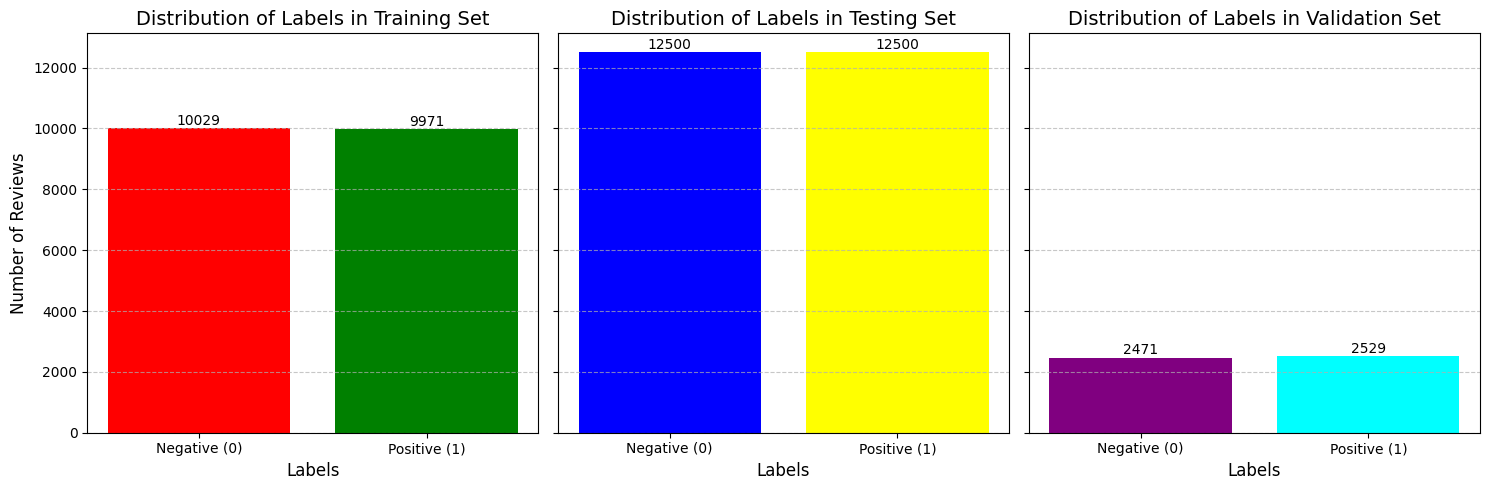

In [5]:
train_label_counts = np.bincount(y_train)
test_label_counts = np.bincount(y_test)
val_label_counts = np.bincount(y_val)
def plot_multiple_label_distributions(label_counts_list, titles, colors_list):
    num_plots = len(label_counts_list)
    fig, axes = plt.subplots(1, num_plots, figsize=(15, 5), sharey=True)
    labels = ['Negative (0)', 'Positive (1)']
    for i, (label_counts, title, colors) in enumerate(zip(label_counts_list, titles, colors_list)):
        axes[i].bar(labels, label_counts, color=colors)
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel('Labels', fontsize=12)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        for j, count in enumerate(label_counts):
            axes[i].text(j, count + 100, str(count), ha='center', fontsize=10)
    axes[0].set_ylabel('Number of Reviews', fontsize=12)
    plt.tight_layout()
    plt.show()
plot_multiple_label_distributions(
    label_counts_list=[train_label_counts, test_label_counts, val_label_counts],
    titles=[
        "Distribution of Labels in Training Set",
        "Distribution of Labels in Testing Set",
        "Distribution of Labels in Validation Set"
    ],
    colors_list=[
        ['red', 'green'],
        ['blue', 'yellow'],
        ['purple', 'cyan']
    ]
)

In [6]:
print(x_test.shape, y_test.shape)

(25000, 200) (25000,)


In [7]:
def scaled_dot_product(q, k, v):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    depth = tf.cast(tf.shape(k)[-1], tf.float32)
    logits = matmul_qk/tf.math.sqrt(depth)
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output

In [8]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model%num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_head(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v):
        batch_size = tf.shape(q)[0]
        q, k, v = self.wq(q), self.wk(k), self.wv(v)
        q, k, v = self.split_head(q, batch_size), self.split_head(k, batch_size),self.split_head(v, batch_size)
        scaled_attention = scaled_dot_product(q, k, v)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output

In [9]:
def point_wise_feedforward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation="relu"),
        tf.keras.layers.Dense(d_model)
    ])

In [10]:
class EncoderLayers(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayers, self).__init__()
        self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.ffn = point_wise_feedforward_network(d_model=d_model, dff=dff)
        self.layerNorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layerNorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate=rate)
        self.dropout2 = tf.keras.layers.Dropout(rate=rate)

    def call(self, x, training):
        attn_output = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layerNorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layerNorm2(ffn_output + out1)
        return out2

In [11]:
import numpy as np
def positional_encoding(position, d_model):
    def get_angles(pos, i, d_model):
        angle_rates = 1/np.power(10000, (2*i//np.float32(d_model)))
        return pos * angle_rates
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model=d_model)
    angle_rads[: ,0::2] = np.sin(angle_rads[: ,0::2])
    angle_rads[: ,1::2] = np.cos(angle_rads[: ,1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [12]:
class TranformerClassifier(tf.keras.Model):
    def __init__(self, num_encoder_layer, d_model, num_heads, dff,
                 input_vocab_size, maximum_position_encoding, rate=0.1):
        super(TranformerClassifier, self).__init__()
        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model=d_model)
        self.enc_layers = [EncoderLayers(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_encoder_layer)]
        self.drop_out = tf.keras.layers.Dropout(rate=rate)
        self.global_average_poolimg = GlobalAveragePooling1D()
        self.final_layer = Dense(1, activation="sigmoid")

    def call(self, x, training):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.drop_out(x, training=training)
        for i in range(num_encoder_layer):
            x = self.enc_layers[i](x, training=training)
        x = self.global_average_poolimg(x)
        return self.final_layer(x)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath="best_model_weights_1.weights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
model = TranformerClassifier(num_encoder_layer=num_encoder_layer, d_model=d_model,
                             num_heads=num_heads, dff=dff, input_vocab_size=vocab_size,
                             maximum_position_encoding=max_len)
model.compile(optimizer= Adam(), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_val, y_val), callbacks=[checkpoint])

Epoch 1/10


I0000 00:00:1740552085.797702    5504 service.cc:146] XLA service 0x72e5380094e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740552085.797805    5504 service.cc:154]   StreamExecutor device (0): Quadro RTX 3000, Compute Capability 7.5
2025-02-26 13:41:25.978882: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-26 13:41:26.585821: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  2/625 ━━━━━━━━━━━━━━━━━━━━ 1:03 102ms/step - binary_accuracy: 0.4453 - loss: 1.2516 

I0000 00:00:1740552095.712947    5504 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - binary_accuracy: 0.5187 - loss: 0.7353
Epoch 1: val_loss improved from inf to 0.38133, saving model to best_model_weights_1.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 111ms/step - binary_accuracy: 0.5188 - loss: 0.7351 - val_binary_accuracy: 0.8330 - val_loss: 0.3813
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - binary_accuracy: 0.8586 - loss: 0.3348
Epoch 2: val_loss improved from 0.38133 to 0.30863, saving model to best_model_weights_1.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - binary_accuracy: 0.8586 - loss: 0.3347 - val_binary_accuracy: 0.8792 - val_loss: 0.3086
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - binary_accuracy: 0.9155 - loss: 0.2162
Epoch 3: val_loss did not improve from 0.30863
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - binary_accuracy: 0.9155 - loss: 0.2162 - val_binary_accuracy: 0.8796 - val_loss: 0.3116
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - binary_accuracy: 0.9435 - los

In [14]:
model.load_weights("best_model_weights.weights.h5")
test_loss, acc_loss = model.evaluate(x_test, y_test)
print(f"Best Test Loss: {test_loss}")
print(f"Best Test Accuracy: {acc_loss}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - binary_accuracy: 0.8738 - loss: 0.3128
Best Test Loss: 0.31480932235717773
Best Test Accuracy: 0.872160017490387


782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step


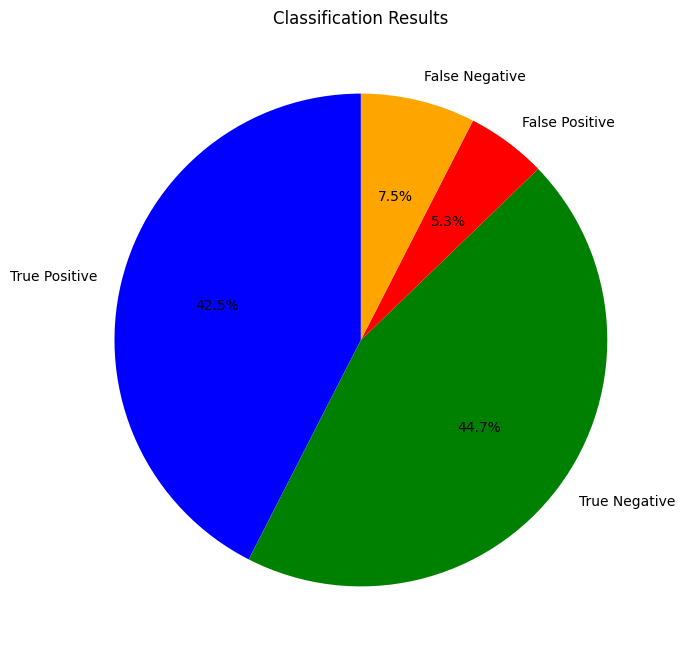

In [15]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).flatten()
true_positive = np.sum((y_test == 1) & (y_pred == 1))
true_negative = np.sum((y_test == 0) & (y_pred == 0))
false_positive = np.sum((y_test == 0) & (y_pred == 1))
false_negative = np.sum((y_test == 1) & (y_pred == 0))
labels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
values = [true_positive, true_negative, false_positive, false_negative]
colors = ['blue', 'green', 'red', 'orange']
plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Classification Results")
plt.show()

In [ ]:
from flask import Flask, request, jsonify
import tensorflow as tf
import numpy as np
import re

app = Flask(__name__)

# Tải bộ từ điển IMDb
word_index = imdb.get_word_index()
# Thêm token đặc biệt
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3
reverse_word_index = {v: k for k, v in word_index.items()}

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

def encode_text(text, max_len=200):
    words = text.split()  
    encoded = [word_index.get(word, 2) for word in words]  
    encoded = encoded[:max_len]  
    return pad_sequences([encoded], maxlen=max_len)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    if 'text' not in data:
        return jsonify({"error": "Missing 'text' parameter"}), 400
    cleaned_text = clean_text(data['text'])
    encoded_text = encode_text(cleaned_text)

    prediction = model.predict(encoded_text)
    predicted_label = int(np.round(prediction).flatten()[0])
    result = {
        "text": data['text'],
        "cleaned_text": cleaned_text,
        "prediction": "positive" if predicted_label == 1 else "negative"
    }
    return jsonify(result)
if __name__ == '__main__':
    app.run(host="0.0.0.0", port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.10:5000
Press CTRL+C to quit


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


127.0.0.1 - - [26/Feb/2025 13:54:16] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


127.0.0.1 - - [26/Feb/2025 13:54:21] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


127.0.0.1 - - [26/Feb/2025 13:55:04] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


127.0.0.1 - - [26/Feb/2025 13:55:34] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


127.0.0.1 - - [26/Feb/2025 13:56:03] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


127.0.0.1 - - [26/Feb/2025 13:56:11] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


127.0.0.1 - - [26/Feb/2025 14:05:01] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


127.0.0.1 - - [26/Feb/2025 14:05:10] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


127.0.0.1 - - [26/Feb/2025 14:05:20] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


127.0.0.1 - - [26/Feb/2025 14:05:29] "POST /predict HTTP/1.1" 200 -
